In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
from arcgis.gis import GIS
import pykrige.uk
from tqdm.notebook import tqdm

## Load Data

In [2]:
well_measurements = pd.read_csv('./brewster_data.csv')
well_measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98134 entries, 0 to 98133
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OBJECTID             98134 non-null  int64  
 1   SITE_CODE            98134 non-null  object 
 2   EWM_STATION_ID       82458 non-null  float64
 3   WELL_NAME            91301 non-null  object 
 4   SWN                  78735 non-null  object 
 5   WELL_USE             98105 non-null  object 
 6   MSMT_DATE            98134 non-null  int64  
 7   WLM_ORG_NAME         84336 non-null  object 
 8   WSE                  98134 non-null  float64
 9   GSE_WSE              98134 non-null  float64
 10  RPE                  98134 non-null  float64
 11  GSE                  98134 non-null  float64
 12  MSMT_ISSUE           62718 non-null  object 
 13  MSMT_YEAR            98134 non-null  int64  
 14  MSMT_SEASON          98134 non-null  object 
 15  COMMENTS             646 non-null   

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
spring_2021 = well_measurements[(well_measurements['MSMT_YEAR']==2013) & (well_measurements['MSMT_SEASON']=='Spring')]

In [4]:
spring_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4147 entries, 0 to 4146
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OBJECTID             4147 non-null   int64  
 1   SITE_CODE            4147 non-null   object 
 2   EWM_STATION_ID       4146 non-null   float64
 3   WELL_NAME            3584 non-null   object 
 4   SWN                  3589 non-null   object 
 5   WELL_USE             4147 non-null   object 
 6   MSMT_DATE            4147 non-null   int64  
 7   WLM_ORG_NAME         4147 non-null   object 
 8   WSE                  4147 non-null   float64
 9   GSE_WSE              4147 non-null   float64
 10  RPE                  4147 non-null   float64
 11  GSE                  4147 non-null   float64
 12  MSMT_ISSUE           4147 non-null   object 
 13  MSMT_YEAR            4147 non-null   int64  
 14  MSMT_SEASON          4147 non-null   object 
 15  COMMENTS             0 non-null      o

Taking only those points whose water surface elevation is lower than ground surface elevation.

In [5]:
spring_2021 = spring_2021[spring_2021['GSE_WSE'] > 0]

In [6]:
spring_2021_x = spring_2021['px']
spring_2021_y = spring_2021['py']
spring_2021_z = spring_2021['GSE_WSE']

Stacking the x, y, and z data together in a new array

In [7]:
spring_2021_xyz = np.vstack((spring_2021_x, spring_2021_y, spring_2021_z)).T

In [8]:
bootstrap_spring_2021_xyz = np.zeros((100, len(spring_2021_xyz), 3))
#for i in range(len(bootstrap_spring_2021_xyz)):
#    bootstrap_indices = np.random.randint(len(spring_2021_xyz), size=len(spring_2021_xyz)*.90)
#    bootstrap_spring_2021_xyz[i] = spring_2021_xyz[bootstrap_indices]
for i in range(len(bootstrap_spring_2021_xyz)):
    boostrap_indices = np.random.choice(spring_2021_xyz

Create kriging grid (current resolution: 0.05 degrees)

In [9]:
gridx = np.arange(-123, -118, 0.05)
gridy = np.arange(34.5, 41, 0.05)

meshgridx, meshgridy = np.meshgrid(gridx, gridy)

Set up bootstrap 

In [10]:
bootstrap_OK = []
for i in tqdm(range(len(bootstrap_spring_2021_xyz))):
    bootstrap_OK.append(pykrige.ok.OrdinaryKriging(bootstrap_spring_2021_xyz[i,:,0], 
                                    bootstrap_spring_2021_xyz[i,:,1],
                                    bootstrap_spring_2021_xyz[i,:,2], 
                                    variogram_model="linear"))

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
bootstrap_z = []
bootstrap_ss = []
for i in tqdm(range(len(bootstrap_OK))):
    z, ss = bootstrap_OK[i].execute("grid", gridx, gridy)
    bootstrap_z.append(z)
    bootstrap_ss.append(ss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
CA_map = gpd.read_file('Shapefiles/CA_State_TIGER2016.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CA_map.crs)
CA_map.to_crs(epsg='4326', inplace=True)

CV_map = gpd.read_file('Shapefiles/Alluvial_Bnd.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CV_map.crs)
CV_map.to_crs(epsg='4326', inplace=True)

PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]
PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PAR

In [13]:
new_binary = mpl.colors.ListedColormap(np.array([[1., 1., 1., 1.],
       [0., 0., 0., 0.]]))
CV_overlay = np.zeros(meshgridx.shape)
CV_geom = CV_map['geometry'].values[0]
for i in tqdm(range(len(CV_overlay))):
    for j in range(len(CV_overlay[0,:])):
        potentialPoint = Point(meshgridx[i,j], meshgridy[i,j])
        if potentialPoint.within(CV_geom):
            CV_overlay[i,j] = 1

  0%|          | 0/130 [00:00<?, ?it/s]

In [14]:
z_mean = np.array(bootstrap_z)
print(z_mean.shape)
z_mean = np.mean(z_mean, axis=0)
print(z_mean.shape)

(100, 130, 100)
(130, 100)


In [15]:
z_var = np.array(bootstrap_z)
z_var = np.sqrt(np.var(z_var, axis=0))
print(z_var.shape)

(130, 100)


/var/folders/6z/fy9gryg51yvcsygp2msy65400000gq/T/ipykernel_14598/2567402667.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(meshgridx, meshgridy, z_mean, zorder=1)
/var/folders/6z/fy9gryg51yvcsygp2msy65400000gq/T/ipykernel_14598/2567402667.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)


Text(303.8240441012261, 0.5, 'Latitude')

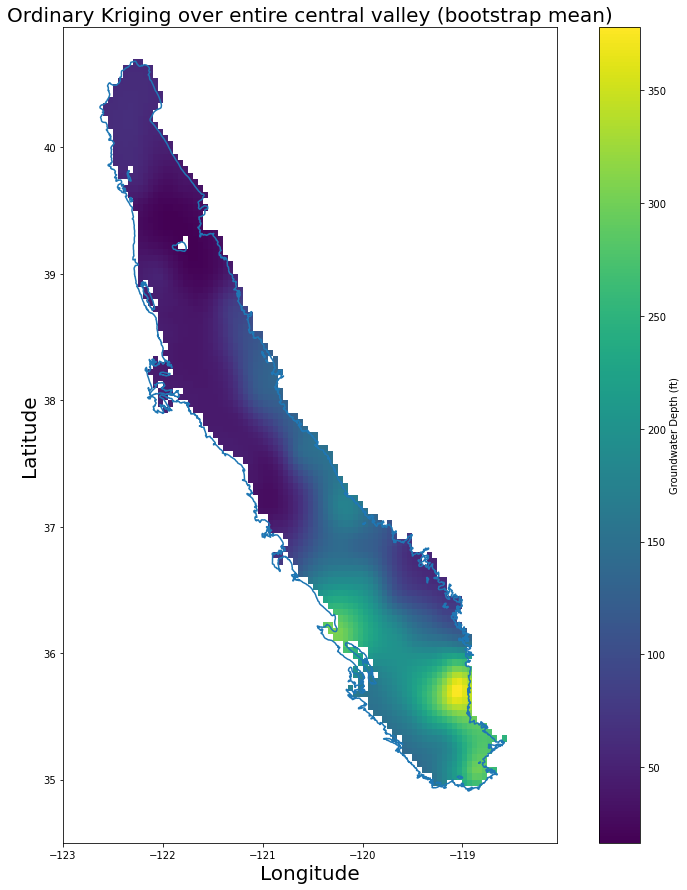

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(meshgridx, meshgridy, z_mean, zorder=1)
plt.colorbar(label='Groundwater Depth (ft)')
plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)
plt.title('Ordinary Kriging over entire central valley (bootstrap mean)', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_bootstrap.png', dpi=300)

/var/folders/6z/fy9gryg51yvcsygp2msy65400000gq/T/ipykernel_14598/3931801867.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(meshgridx, meshgridy, z_var, zorder=1)
/var/folders/6z/fy9gryg51yvcsygp2msy65400000gq/T/ipykernel_14598/3931801867.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)


Text(303.8240441012261, 0.5, 'Latitude')

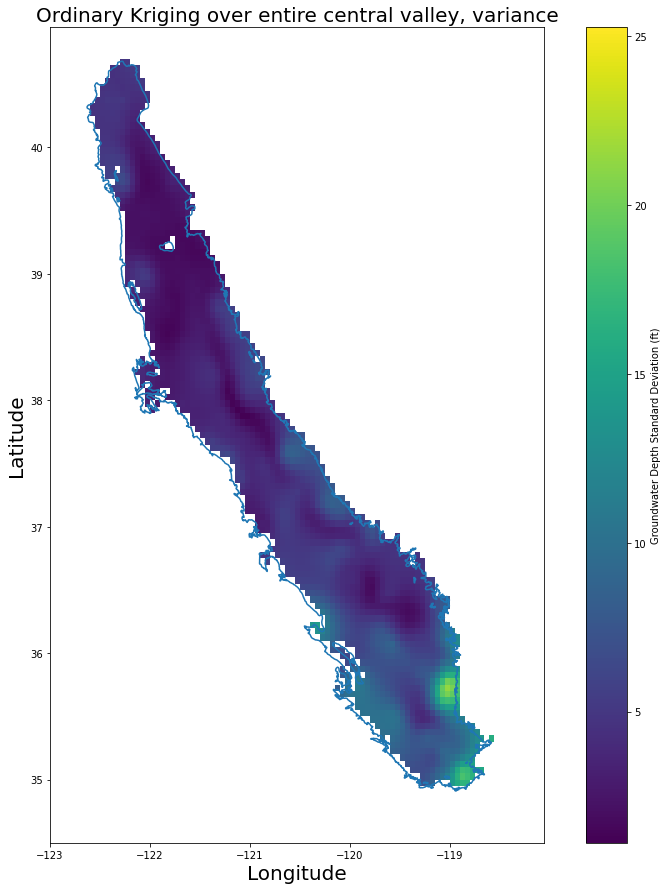

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(meshgridx, meshgridy, z_var, zorder=1)
plt.colorbar(label='Groundwater Depth Standard Deviation (ft)')
plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)
plt.title('Ordinary Kriging over entire central valley, variance', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_vari.png', dpi=300)

piezometer at every well?

consider agricultural and residential wells in areas with not many observation wells

check quality control codes

worried about semiconfined (could be higher than the water table if pressurized) Need some method of confirming if a well is in an unconfined vs semiconfined zone (clay percent? well logs? insar?)

Christina thinks the answer could be in the well logs (line for depth of first water -> water level at level of confirmation)

DWR has some of those logs maybe? still a rangling effort